In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerTuple
from astropy import units as u
from astropy import io
from style import output_folder, base_height, base_width, dpi, bandcols, lc_errbar_kw, lc_uplim_kw, bandmark

# 3HSPJ095507+355101

In [3]:
ra, dec = "09 55 07.8818398488", "+35 51 00.885435048"
hsp_target = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

In [3]:
target.ra.deg, target.dec.deg

(148.78284099937, 35.850245954180004)

## IceCube-2001072A

In [6]:
# Date: 20/01/07
# Time: 09:42:18.36  UT

icecube_loc = EarthLocation(lon=0, lat=-90, height=2450)
hsp_neutrino_time = Time('2020-01-07T09:42:18.36', scale='utc', location=icecube_loc)
# heliocentric correction
ltt_helio = hsp_neutrino_time.light_travel_time(hsp_target, 'heliocentric')
neutrino_time_helio = Time(hsp_neutrino_time.utc - ltt_helio, format='jd', scale='utc', location=icecube_loc)
neutrino_hjd_hsp = neutrino_time_helio.jd

## ASAS-SN data

In [8]:
hsp_fns = {
    "difference phot. + reference": "data/3HSPJ095507+355101_diff_plus_ref_phot.csv",
    "difference photometry": "data/3HSPJ095507+355101_diff_phot.csv",
    "aperture phot.": "data/3HSPJ095507+355101_apperture_phot.csv"
}

hsp_datas = {k: pd.read_csv(v) for k, v in hsp_fns.items()}

# AT2019fdr

In [31]:
ra, dec = 257.278579, 26.855694
tywin_target = SkyCoord(ra, dec, unit=(u.deg, u.deg))

## IceCube-IC200530A

In [32]:
# Date: 20/01/07
# Time: 09:42:18.36  UT

tyein_neutrino_time = Time("2020-05-30T07:54:29.43", scale='utc', location=icecube_loc)
# heliocentric correction
ltt_helio = tyein_neutrino_time.light_travel_time(tywin_target, 'heliocentric')
neutrino_time_helio = Time(tyein_neutrino_time.utc - ltt_helio, format='jd', scale='utc', location=icecube_loc)
tywin_neutrino_hjd = neutrino_time_helio.jd

## ASAS-SN data

In [33]:
tywin_fns = {
    # "difference phot. + reference": "data/3HSPJ095507+355101_diff_plus_ref_phot.csv",
    "difference photometry": "data/at2019fdr_asassn_dif_phot.csv",
    # "aperture phot.": "data/3HSPJ095507+355101_apperture_phot.csv"
}

tywin_datas = {k: pd.read_csv(v) for k, v in tywin_fns.items()}

# Combined plot

3HSPJ095507+355101
closest obs before 0.9771091667935252
closest obs after 10.87368083326146
data goes to -3.04 years before nu
400 
AT2019fdr
closest obs before 0.030707291793078184
closest obs after 0.9864527080208063
data goes to -1.99 years before nu
560 
/Users/jannisnecker/ASASSN_nu_paper_figures/at2019fdr_3hspdifferencephotometry.pdf


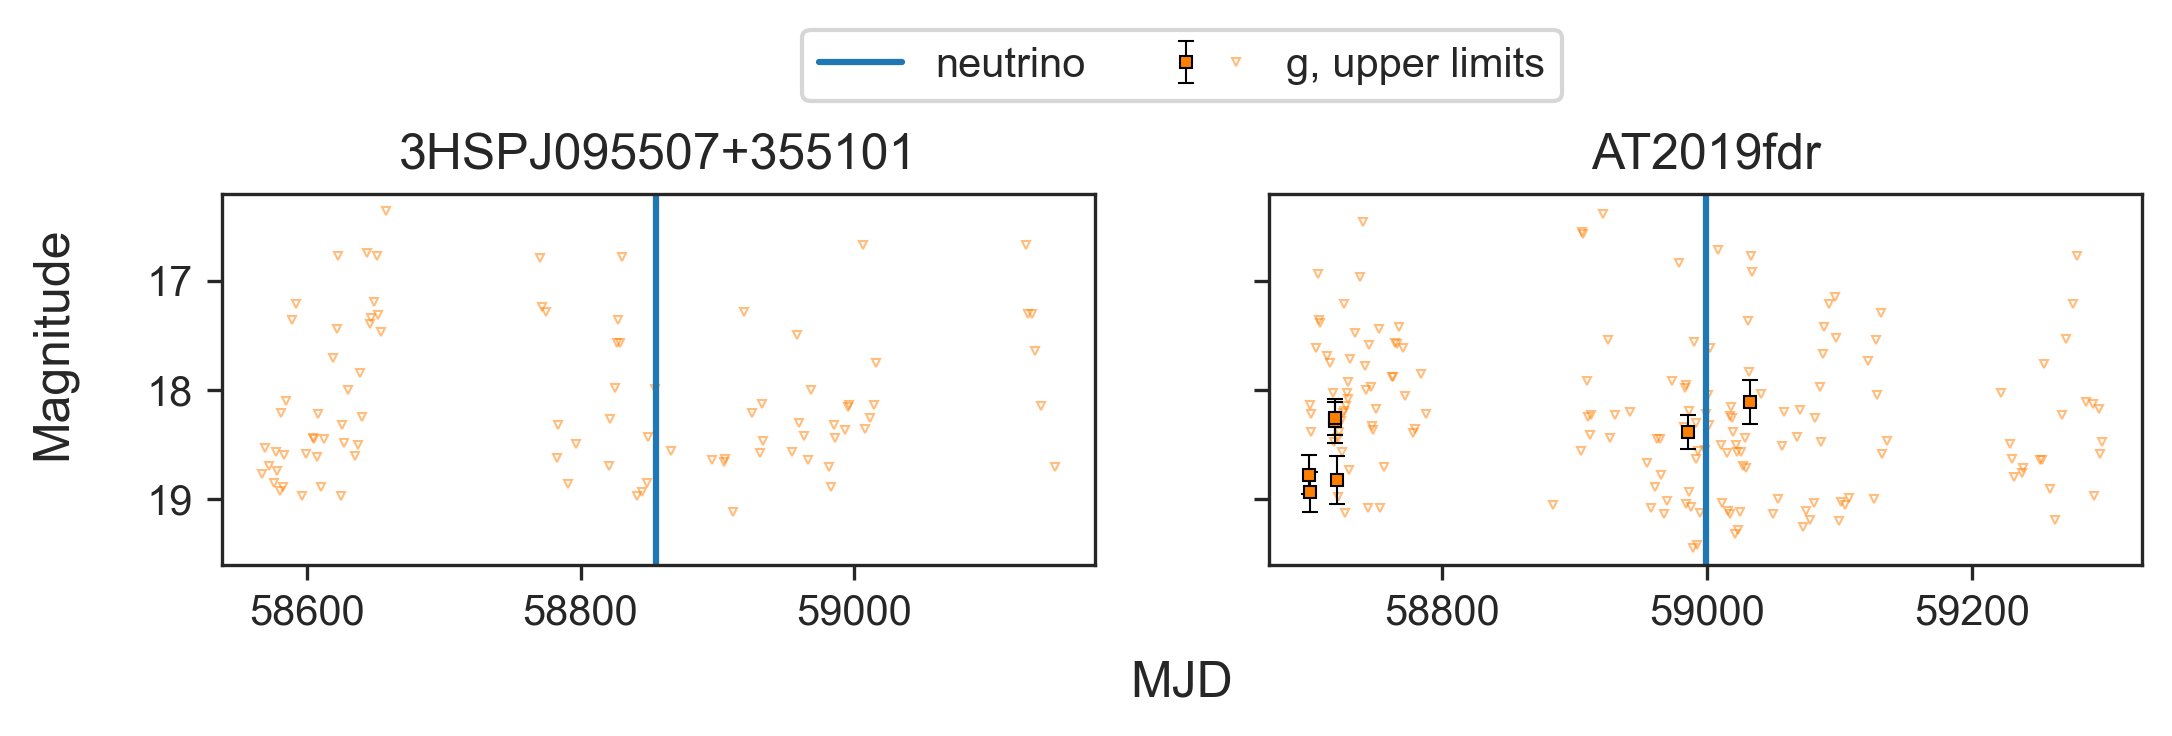

In [74]:
time_from_nu = 300
k = "difference photometry"

fig, axs = plt.subplots(ncols=2, figsize=(base_width*2, base_height), dpi=dpi, sharey='row')

for ax, data, neutrino_time, nuname, tname in zip(
    axs, 
    [hsp_datas[k], tywin_datas[k]], 
    [hsp_neutrino_time, tyein_neutrino_time],
    ["IC2001072A", "IC200530A"],
    ["3HSPJ095507+355101", "AT2019fdr"]
):
    print(tname)
    print("closest obs before", min(neutrino_time.jd - data.HJD[data.HJD < neutrino_time.jd]))
    print("closest obs after", min(data.HJD[data.HJD > neutrino_time.jd] - neutrino_time.jd))
    t_before_m = data.HJD < (neutrino_time.jd - time_from_nu)
    yr_priot = min(data.HJD - neutrino_time.jd) / 365
    print(f"data goes to {yr_priot:.2f} years before nu")

    t_before_m = data.HJD < (neutrino_time.jd - time_from_nu)

    em = data.flux_err < 99.

    tm = abs(data["HJD"] - neutrino_time.jd) <= time_from_nu
    um = data["mag_err"] == 99.99
    print(f"{sum(um)} ")



    line = ax.axvline(neutrino_time.mjd)
    conts = []
    labels = []
    ax.set_title(tname)

    for i, b in enumerate(data.Filter.unique()):
        bm = data.Filter == b
        d = data[bm & em & tm]
        d_meas = data[bm & em & tm & ~um]
        d_ulim = data[bm & em & tm & um]

        a1 = ax.errorbar(
            x=Time(d_meas['HJD'], format='jd').mjd,
            y=d_meas['mag'].astype(float),
            yerr=d_meas['mag_err'],
            color=bandcols[b],
            marker=bandmark[b],
            **lc_errbar_kw
        )

        a2 = ax.plot(
            Time(d_ulim["HJD"], format="jd").mjd,
            d_ulim["Limit"],
            color=bandcols[b],
            **lc_uplim_kw
        )

        if len(d_meas):
            conts.append((a1, a2[0]))
            labels.append(f"{b}, upper limits")

        # ax.scatter(
        #     d_ulim["HJD"],
        #     d_ulim["Limit"],
        #     marker='v',
        #     color=f"C{i}",
        #     alpha=0.5
        # )

        # avg_d = data[bm & em & t_before_m]
        # if len(avg_d):
        #     avg = np.average(avg_d["flux(mJy)"], weights=1/avg_d["flux_err"])
        #     ax.axhline(avg, ls='--', label=r"pre-$\nu$ " + b + "-band average", color=f"C{i}")

    # ax.set_xlim(-time_from_nu, time_from_nu)
    
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
ylim = axs[0].get_ylim()
axs[0].set_ylim(ylim[1], ylim[0])

fig.supxlabel("MJD")
fig.supylabel("Magnitude")
fig.legend([line] + conts, ["neutrino"] + labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc="upper center", ncol=2,
          bbox_to_anchor = (0.5,0.95),bbox_transform = fig.transFigure)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.7)
fig.subplots_adjust(left=0.1)
# fig.tight_layout()
fig_fn = f"{output_folder}at2019fdr_3hsp{k.replace(' ', '').replace('.', '')}.pdf"
print(fig_fn)
fig.savefig(fig_fn)
plt.show()

In [25]:
d_meas

,HJD,UT Date,Camera,FWHM,Limit,mag,mag_err,flux(mJy),flux_err,Filter
